In [11]:
library(repr) ; options(repr.plot.width = 5, repr.plot.height = 6) # Change plot sizes (in cm)

# Model Fitting using Maximum Likelihood

## Introduction


In this Chapter we will work through various examples of  model fitting  to biological data using Maximum Likelihood. It is recommended that you see the [lecture](https://github.com/mhasoba/TheMulQuaBio/tree/master/content/lectures/ModelFitting) on model fitting in Ecology and Evolution. 

[Previously](./20-ModelFitting-NLLS.ipynb), we learned how to fit a mathematical model/equation to data by using the Least Squares method (linear or nonlinear). That is, we choose the parameters of model being fitted (e.g., straight line) to minimize the sum of the squares of the residuals/errors around the fitted model. 

An alternative to minimizing the sum of squared errors is to find parameters to the function such that the * likelihood * of the parameters, given the data and the model, is maximized. Please see the [lectures](https://github.com/vectorbite/VBiTraining2/tree/master/lectures) for the theoretical background to the following examples.

We will first implement the (negative log) likelihood for [simple linear regression (SLR)](./14-regress.ipynb) in R. Recall that SLR assumes every observation in the dataset was generated by the model:

$$
Y_i = \beta_0 + \beta_1 X_i + \varepsilon_i, \;\;\; \varepsilon_i \stackrel{\mathrm{iid}}{\sim} \mathrm{N}(0, \sigma^2)
$$

That is, this is a model for the * conditional distribution * of $Y$ given $X$. The pdf for the normal distribution is given by

$$
f(x) = \frac{1}{\sqrt{2\sigma^2 \pi}} \exp\left(-\frac{(x-\mu)^2}{2\sigma^2} \right)
$$

In the SLR model, the conditional distribution has * this * distribution. 

That is, for any single observation, $y_i$
$$
f(y_i|\beta_0, \beta_1, x_i) = \frac{1}{\sqrt{2\sigma^2 \pi}} \exp\left(-\frac{(y_i-(\beta_0+\beta_1 x_i))^2}{2\sigma^2} \right)
$$

Interpreting this function as a function of the parameters $\theta=\{ \beta_0, \beta_1, \sigma \}$, then it gives us the likelihood of the $i^{\mathrm{th}}$ data point. 

As we did for the simple binomial distribution (see [lecture](https://github.com/vectorbite/VBiTraining2/tree/master/lectures)), we can use this to estimate the parameters of the model.

We will use R. For starters, clear all variables and graphic devices and load necessary packages:

In [12]:
rm(list = ls())
graphics.off()

## Implementing the Likelihood in R

First, we need to build an R function that returns the (negative log) likelihood for simple linear regression (it is negative log because the log of likelihood is itself negative):

In [1]:
nll.slr <- function(par, dat, ...){
 args <- list(...)
 
 b0 <- par[1]
 b1 <- par[2]
 X <- dat$X
 Y <- dat$Y
 if(!is.na(args$sigma)){
  sigma <- args$sigma
 } else 
  sigma <- par[3]

 mu <- b0+b1 * X
 
 return(-sum(dnorm(Y, mean=mu, sd=sigma, log=TRUE)))
}

Note that we do something a bit different here (the "`...`" bit). We do it this way because we want to be able to use R's `optim()` function later.

The `dnorm()` function calculates the logged (the `log=TRUE` argument) probability of observing Y given mu, sigma and that X. 

The negative sign on `sum()` is because the `optim()` function in R will minimize the negative log-likelihood, which is a sum: Recall that The log-likelihood of the parameters $\theta$ being true given data x equals to the sum of the logged probability densities of observing the data x given parameters $\theta$. We want to maximize this (log-) likelihood using `optim()`.

Let's generate some simulated data, assuming that: $\beta_0=$ `b0`, $\beta_1=$ `b1`, and $\sigma=$ `sigma`. For this, we will generate random deviations to simulate sampling or measurement error around an otherwise perfect line of data values:

In [2]:
set.seed(123)
n <- 30
b0 <- 10
b1 <- 3
sigma <- 2
X <- rnorm(n, mean=3, sd=7)
Y <- b0 + b1 * X + rnorm(n, mean=0, sd=sigma)
dat <- data.frame(X=X, Y=Y) # convert to a data frame

In the first line, we `set.seed()` to ensure that we can reproduce the results. The seed number you choose is the starting point used in the generation of a sequence of random numbers. No plot the "data":

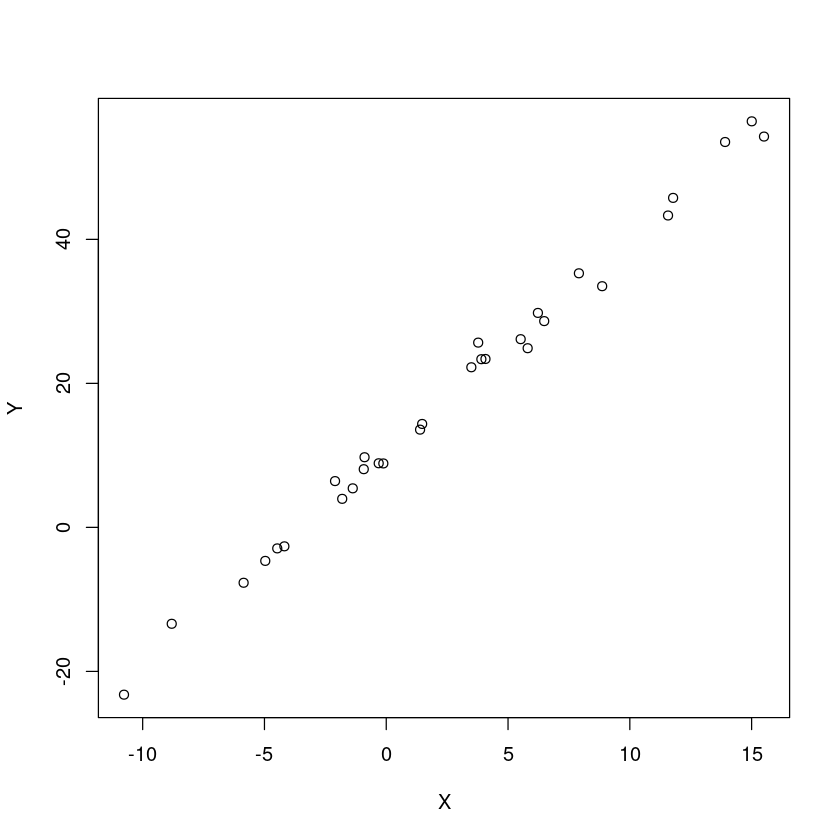

In [3]:
plot(X, Y)

### Likelihood profile

For now, let's assume that we know what $\beta_1$ is. Let's build a likelihood profile for the simulated data:

In [5]:
N <- 50
b0s <- seq(5, 15, length=N)
mynll <- rep(NA, length=50)
for(i in 1:N){
 mynll[i] <- nll.slr(par=c(b0s[i],b1), dat=dat, sigma=sigma)
}

That is, we calculate the negative log-likelihood for fixed b1, across a range (5 - 15) of b0. 

Now plot the profile:

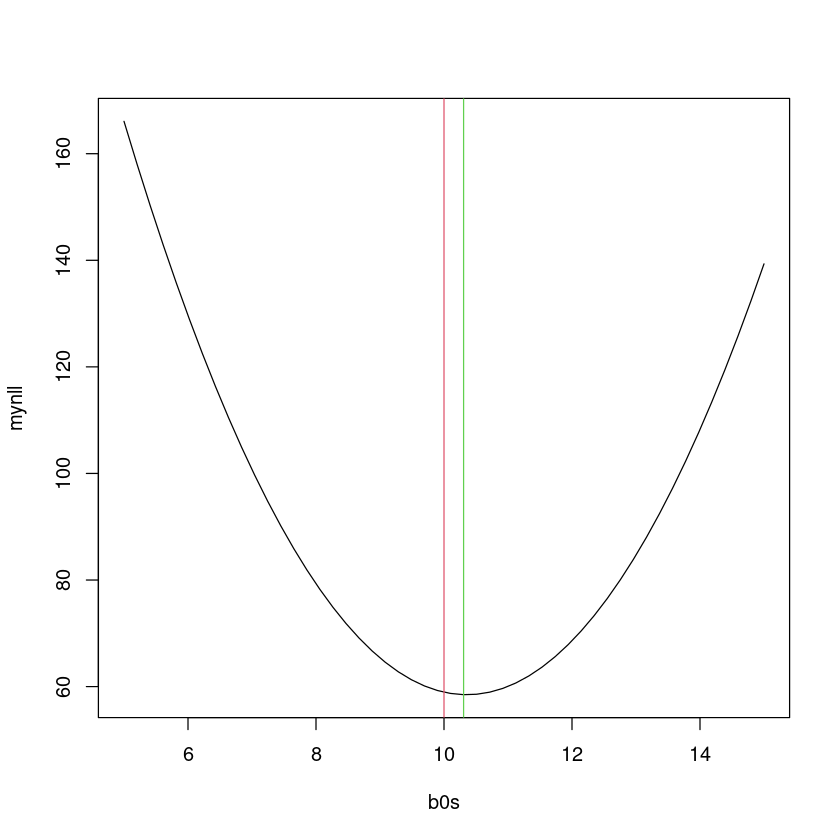

In [6]:
plot(b0s, mynll, type="l")
abline(v=b0, col=2)
abline(v=b0s[which.min(mynll)], col=3)

The true value for b0 (10) is the red line, while the value that minimizes the log-likelihood (i.e., maximizes the negative log-likelihood) is the green line. These are not the same because maximum likelihood is providing an * estimate * of the true value given the measurement errors (that we ourselves generated in tgis synthetic dataset). 

(ModelFitting-MLE-LikelihoodSurface)=
### Likelihood surface

If we wanted to estimate both $\beta_0$ and $\beta_1$ (two parameters), we need to deal with a two-dimensional maximum likelihood surface. The simplest approach is to do a *grid search* to find this likelihood surface.

10.00000,3.00
10.48485,2.96


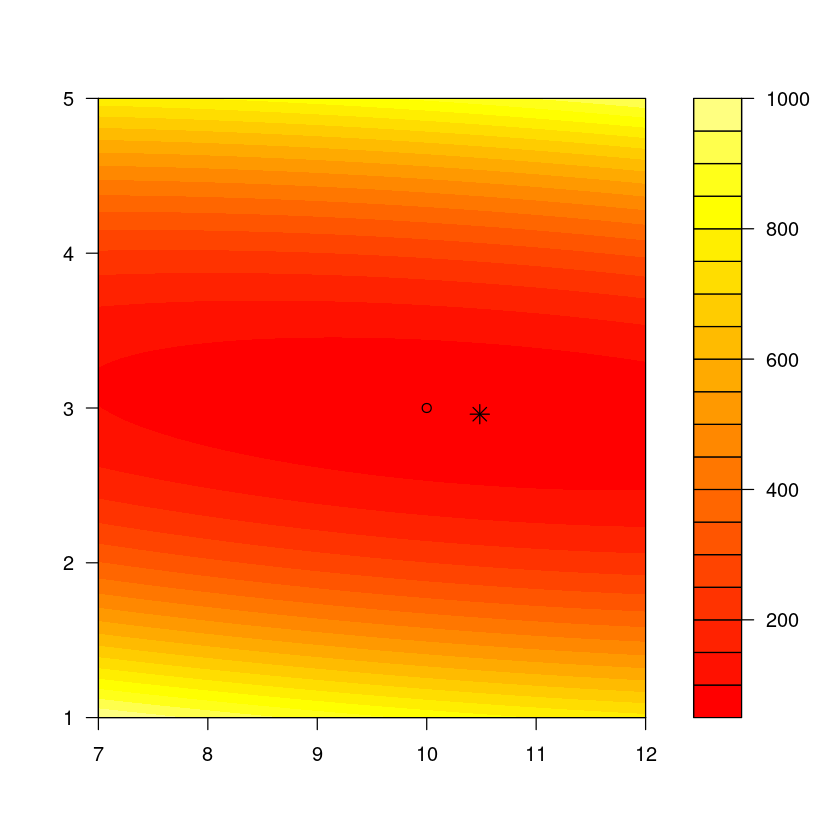

In [7]:
N0 <- 100
N1 <- 101
b0s <- seq(7,12, length=N0)
b1s <- seq(1,5, length=N1)

mynll <- matrix(NA, nrow=N0, ncol=N1)
for(i in 1:N0){
 for(j in 1:N1) mynll[i,j] <- nll.slr(par=c(b0s[i],b1s[j]), dat=dat, sigma=sigma)
}

ww <- which(mynll==min(mynll), arr.ind=TRUE)

b0.est <- b0s[ww[1]]
b1.est <- b1s[ww[2]]
rbind(c(b0, b1), c(b0.est, b1.est))

filled.contour(x = b0s, y = b1s, z= mynll, col=heat.colors(21), 
    plot.axes = {axis(1); axis(2); points(b0,b1, pch=21); 
       points(b0.est, b1.est, pch=8, cex=1.5); xlab="b0"; ylab="b1"})

There is a lot going on here. Make sure you ask one of us if some of the code does not make sense!

Again, note that the true parameter combination (asterisk) and the one what maximizes the negative log-likelihood (circle) are different.

### Conditional Likelihood
We can also look at the conditional surfaces (i.e., we look at the slice around whatever the best estimate is for the other parameter):

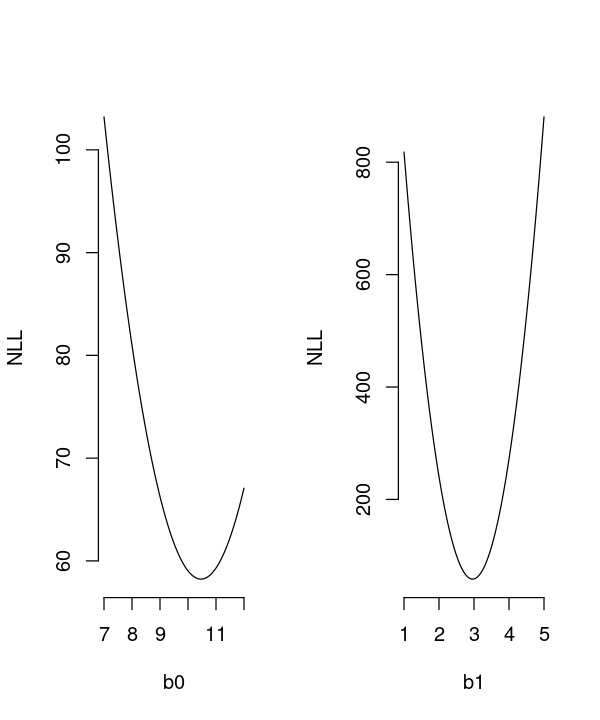

In [60]:
par(mfrow=c(1,2), bty="n")
plot(b0s, mynll[,ww[2]], type="l", xlab="b0", ylab="NLL")
plot(b1s, mynll[ww[1],], type="l", xlab="b1", ylab="NLL")

## Alternatives to Grid Search

There are many alternative methods to grid searches. Since we are seeking to minimize an arbitrary function (the negative log likelihood) we typically use a descent method to perform general optimization.

There are lots of options implemented in the `optim`function in R. We won't go into the details of these methods, due to time constraints. However, typically one would most commonly use:

 * Brent's method: for 1-D search within a bounding box, only
 * L-BFGS-B (limited-memory Broyden–Fletcher–Goldfarb–Shanno algorithm with bounding box constraints): a quasi-Newton method, used for higher dimensions, when you want to be able to put simple limits on your search area. 
 

## Maximum Likelihood using `optim()`

We can now do the fitting. This involves optimization (to find the appropriate parameter values that achieve the maximum of the likelihood surface above). For this, we will use R's versatile `optim()` function.

The first argument for `optim()` is the function that you want to minimize, and the second is a vector of starting values for your parameters (as always, do a`?optim`). After the main arguments, you can add what you need to evaluate your function (e.g. `sigma` ). The addtional argument sigma can be "fed" to `nll.slr` because we use the `...` convention when defining it.

In [61]:
fit <- optim(nll.slr, par=c(2, 1), method="L-BFGS-B", ## this is a n-D method
    lower=-Inf, upper=Inf, dat=dat, sigma=sigma)

fit

$par
[1] 10.458935  2.961704

$value
[1] 58.22473

$counts
function gradient 
      12       12 

$convergence
[1] 0

$message
[1] "CONVERGENCE: REL_REDUCTION_OF_F <= FACTR*EPSMCH"

Easy as pie (once you have the recipe)! We can also fit sigma as the same time if we want:

In [62]:
fit <- optim(nll.slr, par=c(2, 1, 5), method="L-BFGS-B", ## this is a n-D method
    lower=c(-Inf, -Inf, 0.1), upper=Inf, dat=dat, sigma=NA)
fit$par

[1] 10.458945  2.961704  1.621689

The starting values (b0 = 2, b1 = 1, sigma = 5) need to be assigned as we would do for NLLS. Also note that much like NLLS, we have bounded the parameters. The exact starting values are not too important in this case (try changing them see what happens).

Now visualize the fit:

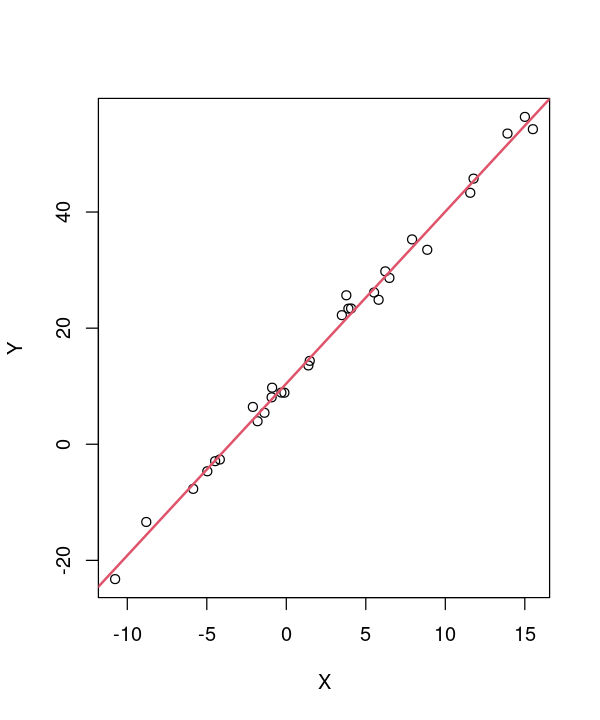

In [63]:
plot(X, Y)
abline(a=fit$par[1], b=fit$par[2], col=2, lwd=2)

### Confidence intervals

The joint distribution of the MLEs are asymptotically Normally distributed. Given this, if you are minimizing the negative log likelihood (NLL) then the covariance matrix of the estimates is (asymptotically) the inverse of the Hessian matrix. The Hessian matrix evalutes the second derivatives of the NLL (numerically here), which gives us information about the curvature the likelihood. Thus we can use the Hessian to estimate confidence intervals:

In [64]:
fit <- optim(nll.slr, par=c(2, 1), method="L-BFGS-B", hessian=TRUE, lower=-Inf, upper=Inf, dat=dat, sigma=sigma)

fisher_info <- solve(fit$hessian)
est_sigma <- sqrt(diag(fisher_info))
upper <- fit$par+1.96 * est_sigma
lower <- fit$par-1.96 * est_sigma
interval <- data.frame(value=fit$par, upper=upper, lower=lower)
interval

value,upper,lower
<dbl>,<dbl>,<dbl>
10.458935,11.228565,9.689305
2.961704,3.067705,2.855704


### Comparison to fitting with least squares

We can, of course, simply fit the model with lest squares using the `lm()` function:

In [65]:
lmfit <- lm(Y~X)

summary(lmfit)$coeff

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),10.458936,0.32957007,31.73509,1.699822e-23
X,2.961704,0.04539126,65.24834,3.874555e-32


The estimates we get using `optim()` are almost identical to the estimates that we obtain here, and the standard errors on the intercept and slope are very similar to those we calculated from the Hessian (est_sigma= `r est_sigma`). 

## Model Selection

You can use [AIC or BIC as you did in NLLS](#Comparing-models) using the likelihood you have calculated. 

You can also use the Likelihood Ratio Test (LRT).

## Exercises <a id='MLE_Exercises'></a> 

Try MLE fitting for the allometric trait data example [above](#Allometric-scaling-of-traits). You will use the same data + functions that you used to practice fitting curves using non-linear least squares methods. You have two options here. The easier one is to convert the power law model to a straight line model by taking a log (explained the Allometry [Exercises](#Allom_Exercises). Specifically,

(a) Using the [`nll.slr`](#Implementing-the-Likelihood-in-R) function as an example, write a function that calculates the negative log likelihood as a function of the parameters describing your trait and any additional parameters you need for an appropriate noise distribution (e.g., $\sigma$ if you have normally distributed errors).

(b) For at least one of your parameters plot a likelihood profile given your data, with the other parametes fixed.

(c) Use the `optim` function to find the MLE of the same parameter and indicate this on your likelihood profile.

(d) Obtain a confidence interval for your estimate.

A more challenging option is to fit the allometry data directly to the power law equation. You would need to assume a log-normal distribution for the errors instead of normal, in this case. 

Readings and Resources <a id='Readings'></a>
--------------------------------------------
 * Bolker, B. Ecological models and data in R. (Princeton University Press, 2008). 